## **Topic Modeling**


> Downloading necessary API


> Declaration of class and API function





In [ ]:
# This code is referenced by https://www.kaggle.com/dskswu/topic-modeling-bert-lda.
# Most of codes are from the link.
#!pip install umap-learn
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers
!pip install stop-words

     |████████████████████████████████| 998 kB 8.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993431 sha256=5fe16b460af439c7b5542c02dd660e84236cffb1a1d940e499989822e43cbe4c
  Stored in directory: /root/.cache/pip/wheels/89/79/3b/9885ae7f4308f73c514f96d8574d40d7d8173a27731b674013
Successfully built langdetect
  Created wheel for language-detector: filename=language_detector-5.0.2-py3-none-any.whl size=7054 sha256=a5c1ce8d3fc91450468285716252f22afa62a9d2535519ac919e83f248cf373a
  Stored in directory: /root/.cache/pip/wheels/12/40/73/a0765d65e793332b79dfe6c34c713e7c0066ea785191b3f50a
Successfully built language-detector
     |████████████████████████████████| 2.6 MB 7.7 MB/s 
     |████████████████████████████████| 125 kB 7.5 MB/s 
     |████████████████████████████████| 79 kB 4.4 MB/s 
     |████████████████████████████████| 4.0 MB 53.8 MB/s 
     |████████████████████████████████| 1.2 MB 52.4 MB/s 
     |████████████████████████████████| 77 kB 

In [ ]:
# linear algebra
# data processing, CSV file I/O (e.g. pd.read_csv)
import os

import json
import pandas as pd
from tqdm import tqdm
import numpy as np
from nltk.corpus import wordnet
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
# import umap.umap_ as umap

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go

import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# from google.colab import files
# uploaded = files.upload()
# import io
# meta = pd.read_csv(io.BytesIO(uploaded['piazza data anonymized.csv']))
# #meta = pd.read_csv(io.BytesIO(uploaded['Sample_data.csv']))

# # Figure 

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive")
meta = pd.read_csv('piazza data anonymized.csv')

In [ ]:
# Preprocessing

from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import re
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from language_detector import detect_language

import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    
###################################
#### sentence level preprocess ####
###################################

# lowercase + base filter
# some basic normalization
def f_base(s):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()


# language detection
def f_lan(s):
    """
    :param s: string to be processed
    :return: boolean (s is English)
    """

    # some reviews are actually english but biased toward french
    return detect_language(s) in {'English', 'French','Spanish','Chinese'}


###############################
#### word level preprocess ####
###############################

# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    #|set(get_stop_words('cy'))
    |set(get_stop_words('pt'))
    #|set(get_stop_words('tl'))
    |set(get_stop_words('pl'))
    #|set(get_stop_words('et'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    #|set(get_stop_words('so'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    #|set(get_stop_words('cs'))
    |set(get_stop_words('nl'))
    #|set(get_stop_words('sl'))
    #|set(get_stop_words('no'))
    #|set(get_stop_words('zh-cn'))
))





def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]


def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s


def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from collections import Counter
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import os

def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))
    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
        return
    lbs = model.cluster_model.labels_
    vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)


def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)

def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    if model.method == 'LDA':
        return
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
    tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])

    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
  
    print('Getting wordcloud for topic {}. Done!'.format(topic))

## **Encorder Class**

In [ ]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

### **Preprocess the data and Topic Model Class**

In [ ]:
from nltk import corpus
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
#from Autoencoder import *
#from preprocess import *
from datetime import datetime


def preprocess(docs, samp_size=None, replace=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    # samp = list(range(100))
    samp = np.random.choice(n_docs, samp_size, replace)
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists, idx_in


# define model object
class Topic_Model:
    def __init__(self, k=10, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

            
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans
        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################
        print(self.corpus)
        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary, random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')
        print(self.cluster_model)
    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)
        print(vec)
        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
            
        else:
            lbs = self.cluster_model.predict(vec)
            
        print(lbs)
        return lbs

## **Pre-Trained Model**

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=Warning)

import argparse

#def model(): #:if __name__ == '__main__':

method = "LDA_BERT"
ntopic = 6
    #parser = argparse.ArgumentParser(description='contextual_topic_identification tm_test:1.0')
    #parser.add_argument('--fpath', default='/kaggle/working/train.csv')
    #parser.add_argument('--ntopic', default=10,)
    #parser.add_argument('--method', default='TFIDF')
    #parser.add_argument('--samp_size', default=20500)
    #args = parser.parse_args()
data = meta
    #pd.read_csv('/kaggle/working/train.csv')
data = data.fillna('')  # only the comments has NaN's
rws = data['Submission_HTML_Removed_coding'] # csv sentense column
samp_size = len(rws)
sentences, token_lists, idx_in = preprocess(rws, samp_size=samp_size, replace=False) 
tm = Topic_Model(k = ntopic, method = 'LDA_BERT') # pre-training
    # Fit the topic model by chosen method
tm.fit(sentences, token_lists)
    # Evaluate using metrics
#with open("/kaggle/working/{}.file".format(tm.id), "wb") as f:
  #    pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)
print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
#  print('Silhouette Score:', get_silhouette(tm))
    # visualize img

Preprocessing raw texts ...
Preprocessing raw texts. Done!
[[(0, 1)], [(1, 1)], [(2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(6, 1), (10, 1), (11, 1), (12, 1), (13, 1)], [(14, 1), (15, 1)], [(16, 1)], [(3, 1), (7, 1), (17, 1), (18, 1), (19, 2), (20, 1)], [(3, 1), (6, 1), (10, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(12, 1), (26, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)], [(34, 1)], [(35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(14, 1), (40, 1), (41, 1)], [(24, 1), (42, 1)], [(24, 1), (33, 1), (34, 1), (43, 1), (44, 1), (45, 1)], [(45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)], [(2, 1), (34, 1), (53, 1), (54, 1), (55, 1)], [(34, 1)], [(4, 1), (6, 1), (56, 1), (57, 1)], [(14, 1), (33, 2), (46, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)], [(6, 1), (17, 1), (19, 2), (24, 2), (33, 1), (39, 2), (46, 1), (59, 1), (65, 1), (66, 1), (67, 1)], [(68, 2), (69, 1), (70, 1), (71, 1)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/397 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
Clustering embeddings. Done!
KMeans(n_clusters=6)
Coherence: 0.5798908690842538


##  Preprocessing and Predicting with the pre-trained model

In [ ]:
stc= rws.apply(lambda x: preprocess_sent(x)) # preprocessing sentences
tokens = stc.apply(lambda x: preprocess_word(x)) # tokenizing

Saving the model

In [ ]:
import pickle

In [ ]:
filename = 'finalized_LDAmodel.sav'
pickle.dump(tm, open(filename, 'wb'))

2022-04-17 22:06:58,380 WARNING:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2022-04-17 22:06:58,754 WARNING:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [ ]:
data_sentence=[x for x in stc if x is not None]
data_tokens =[x for x in tokens if x is not None]
# Empty sentence and tokens are eliminated.

Load the model

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(data_sentence, data_tokens, out_of_sample=True)
print(result)

2022-04-17 22:08:51,486 WARNING:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2022-04-17 22:08:51,681 WARNING:No training configuration found in save file, so the model was *not* compiled. Compile it manually.


Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
[[ 7.408166    7.5764256   3.952016   ...  4.633977    0.
   3.5006108 ]
 [ 8.451645    5.9501877   5.7910995  ...  5.956196    0.
   5.186598  ]
 [ 6.509112    6.812259    3.4512055  ...  4.1184034   0.
   6.8584228 ]
 ...
 [ 8.157108    3.8045874   2.5205033  ...  4.8657594   0.
   4.8299003 ]
 [ 6.5635185   3.8784304   4.6311636  ...  3.060886    0.
   2.8370678 ]
 [12.819528    4.713191    1.0358415  ...  0.38311648  0.
   3.5004067 ]]
[[ 7.408166    7.5764256   3.952016   ...  4.633977    0.
   3.5006108 ]
 [ 8.451645    5.9501877   5.7910995  ...  5.956196    0.
   5.186598  ]
 [ 6.509112    6.812259    3.4512055  ...  4.1184034   0.
   6.8584228 ]
 ...
 [ 8.157108    3.8045874   2.5205033  ...  4.8657594   0.
   4.8299003 ]
 [ 6.5635185   3.8784304   4.6311636  ...  3.060886    0.
   2.8370678 ]
 [12.819528    4.713191    1.0358415  ...  0.38311648  0.
   3.5004067 ]]
[2 2 0 ... 2 5 4]
[2 2 0 ... 2 5 4]


In [ ]:
# #stc = [x for x in stc if x is not None else ' ']
# st = []
# tks = []
# for x in stc:
#   if x is None:
#     x = " "
#   st.append(x);

# for x in tokens:
#   if x is None:
#     x = [' ']
#   tks.append(x);
# # tokens = [x for x in tokens if x is not None else ' ']
# # tm.predict(sentences=stc, token_lists=tokens, out_of_sample=True)
# # vectorized=tm.vectorize(stc, tokens, "LDA_BERT")
# print(st)
# print(tks)
# We might use this later to deal with empty array for sentences and tokens.

[' ', ' ', ' ', ' ', "did you save the notebook code back out to your submission. py? have you tried running without the notebook, but running the vector tests python file that's included in the repo?", ' ', ' ', 'can you try without sorting your output? i think gradescope is not checking the sorted output while the test case in jupyter notebook checks for sorted. i will check again, but meanwhile please try this. also please check if you are using any hashing, then the ordering may get messed up.', "<name> tests seem overly restrictive on timings. <name>y randomly fail on my machine here because it might take say 0. 124ms instead of 0. 09ms. i'm 90% sure i have the right implementation and it passes on gradescope too.", 'yeah, same here. i was failing the timing test for loops locally, but passed it on gd.\n<name>ver, i am seeing some weird issue with the flatten. it passed locally, but not on gd', 'i am not using notebook. directly ran the provided tests, but seeing the same problem.

In [ ]:
topicnames = ["Topic"]
docnames = ["Doc" + str(i) for i in range(len(result))]
df_document_topic = pd.DataFrame(np.round(result, 2), columns = topicnames, index = docnames)
print(df_document_topic)

         Topic
Doc0         2
Doc1         2
Doc2         0
Doc3         0
Doc4         2
...        ...
Doc1207      4
Doc1208      0
Doc1209      2
Doc1210      5
Doc1211      4

[1212 rows x 1 columns]


Sorting topic counts

In [ ]:
# Descending order
unsorted = [0] * ntopic

for topic in df_document_topic["Topic"]:
  unsorted[topic] = unsorted[topic] + 1
print(unsorted)
topic_distribution = sorted(unsorted,reverse=True)
print(topic_distribution)

xindex = []
for i in topic_distribution:
  for j in range(ntopic):
    if i == unsorted[j]:
      print()
      xindex.append(j)
      continue
print(xindex)
print(topic_distribution)


[185, 138, 179, 234, 273, 203]
[273, 234, 203, 185, 179, 138]






[4, 3, 5, 0, 2, 1]
[273, 234, 203, 185, 179, 138]


## **Visualization for our models**

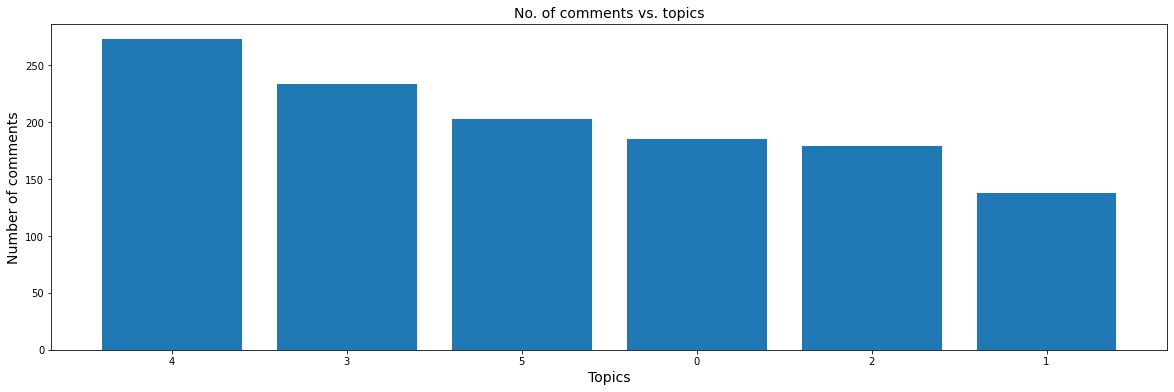

[273, 234, 203, 185, 179, 138]


In [ ]:
plt.figure(figsize=(20,6))
x = np.arange(len(xindex))
plt.title('No. of comments vs. topics', fontsize = 14)
plt.ylabel('Number of comments', fontsize = 14)
plt.xlabel('Topics', fontsize = 14)
plt.bar(x, topic_distribution)
plt.xticks(x, xindex)
plt.show()
print(topic_distribution)

**pyLDAvis**

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# feed the LDA model into the pyLDAvis instance
lda_out = gensim.models.ldamodel.LdaModel(corpus=tm.corpus, num_topics=6, id2word=tm.dictionary, random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=6,
                                           alpha='auto',
                                           per_word_topics=True)
doc_lda = lda_out[tm.corpus]

pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_out, tm.corpus, tm.dictionary)
lda_viz
#lda_model.fit_transform(data_vectorized)

     |████████████████████████████████| 1.7 MB 13.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=86c7a49a6dfa519eced49e79be5115b8566c6015a383ae8321156f1afa879444
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [ ]:
def format_topics_sentences(ldamodel=tm.ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=tm.ldamodel, corpus=tm.corpus, texts=data_sentence)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5831,"name, submiss, thank, bonu, haggl, code, compl...",did you save the notebook code back out to you...
1,1,1.0,0.5831,"name, submiss, thank, bonu, haggl, code, compl...",can you try without sorting your output? i thi...
2,2,3.0,0.5823,"probabl, valu, test, line, alarm, gaug, error,...",<name> tests seem overly restrictive on timing...
3,3,4.0,0.6476,"featur, class, decis, return, tree, node, self...","yeah, same here. i was failing the timing test..."
4,4,1.0,0.8607,"name, submiss, thank, bonu, haggl, code, compl...",i am not using notebook. directly ran the prov...
...,...,...,...,...,...
95,95,0.0,0.7905,"assign, part, post, name, discuss, pleas, than...","unfortunately, we cannot terminate the running..."
96,96,1.0,0.5819,"name, submiss, thank, bonu, haggl, code, compl...",thanks guarav!
97,97,1.0,0.7898,"name, submiss, thank, bonu, haggl, code, compl...",resolved
98,98,3.0,0.9073,"probabl, valu, test, line, alarm, gaug, error,...",can you share your gradescope submission? noth...


In [ ]:
count = [0] * ntopic
for topic in df_document_topic["Topic"]:
  count[topic] = count[topic] + 1
print(count)

[185, 138, 179, 234, 273, 203]


In [ ]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()


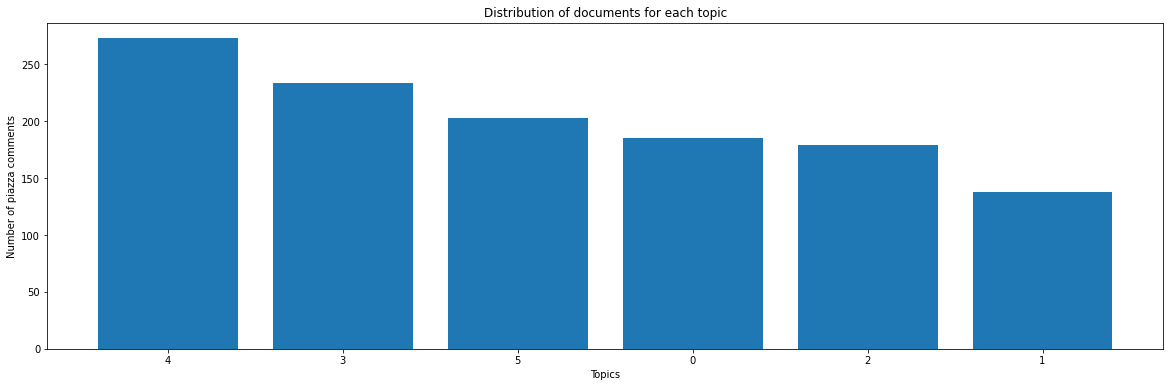

1.0    311
3.0    291
0.0    204
2.0    137
4.0     99
5.0     95
Name: Dominant_Topic, dtype: int64
[273, 234, 203, 185, 179, 138]


In [ ]:
plt.figure(figsize=(20,6))
x = np.arange(len(xindex))
plt.title('Distribution of documents for each topic')
plt.ylabel('Number of piazza comments')
plt.xlabel('Topics')
plt.bar(x, topic_distribution)
plt.xticks(x, xindex)
plt.show()
print(topic_counts)
print(topic_distribution)

## **Visualization Bubble**

In [ ]:
topics_dic = {
    'topic_distribution': topic_distribution,
    'numOfTopic': xindex,
    'color': ['#2EB62C', '#57C84D', '#83D475', '#ABE098', '#C5e8b7', '#D6e8b6']
}

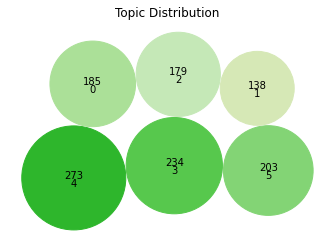

Getting wordcloud for topic 4 ...
Getting wordcloud for topic 4. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!


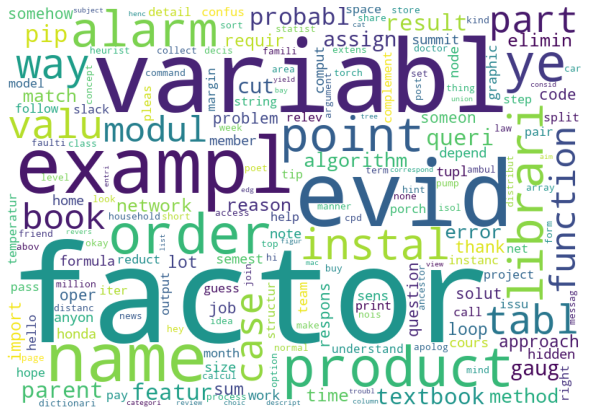

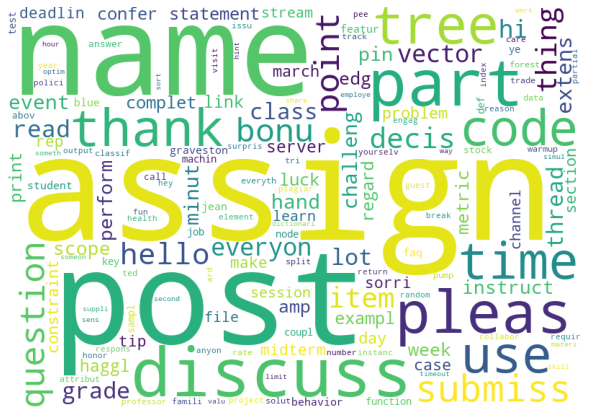

In [ ]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, label2, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='top')
            ax.text(*self.bubbles[i, :2], label2[i],
                    horizontalalignment='center', verticalalignment='baseline')

bubble_chart = BubbleChart(area= topics_dic['topic_distribution'], bubble_spacing=0.2)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, topics_dic['numOfTopic'], topics_dic['topic_distribution'], topics_dic['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Topic Distribution')

plt.show()
get_wordcloud(tm, token_lists, xindex[0])
get_wordcloud(tm, token_lists, xindex[1])